## Prediction heatmaps
The gold standard & different models are the columns, and the words in the gold standard are the rows. Here, I'll experiment with different groupsings of the rows to help visualize what, if any, the differences are in the types of entities that the models tend to predict.

I'll make separate plots for unigrams, bigrams, and trigrams.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import jsonlines
import pandas as pd
import numpy as np

In [4]:
data = {'gold_std':'../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/all_gold_standard_abstracts_GOLD_STD_10Jan2022.jsonl',
       'dygiepp_ace05':'../data/straying_off_topic_data/dygiepp/pretrained_output/lightweight/ace05/all_gold_standard_abstracts_10Jan2022_ace05_predictions.jsonl',
       'dygiepp_scierc_light':'../data/straying_off_topic_data/dygiepp/pretrained_output/lightweight/scierc-light/all_gold_standard_abstracts_10Jan2022_scierc-light_predictions.jsonl',
       'dygiepp_genia_light':'../data/straying_off_topic_data/dygiepp/pretrained_output/lightweight/genia-light/all_gold_standard_abstracts_10Jan2022_genia-light_predictions.jsonl',
       'dygiepp_genia':'../data/straying_off_topic_data/dygiepp/pretrained_output/withCoref/genia/all_gold_standard_abstracts_10Jan2022_genia_predictions.jsonl',
       'dygiepp_scierc':'../data/straying_off_topic_data/dygiepp/pretrained_output/withCoref/scierc/all_gold_standard_abstracts_10Jan2022_scierc_predictions.jsonl',
       'phrasematched_plain':'../data/straying_off_topic_data/model_output/keyword_match/phrasematch_plain/all_gold_10Jan2022_phrasematched_plain_dygiepp_format.jsonl',
       'phrasematched_refined':'../data/straying_off_topic_data/model_output/keyword_match/phrasematch_refined/all_gold_10Jan2022_phrasematched_refined_dygiepp_format.jsonl',
       'pure_ace05':'../data/straying_off_topic_data/model_output/pure/ace05/ent-alb-ctx100/ace05_ent_pred_dev.json',
       'pure_scierc':'../data/straying_off_topic_data/model_output/pure/scierc/ent-scib-ctx300/scierc_ent_pred_dev.json'}

First, need to affirm that the documents in all prediction sets are in the same order:

In [5]:
# Read in all datasets
for name, filepath in data.items():
    contents = []
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            contents.append(obj)
    data[name] = contents

In [6]:
# Reorder based on value of "doc_key" so they're all in the same order
for name, dataset in data.items():
    sorted_dataset = sorted(dataset, key=lambda d: d['doc_key'])
    data[name] = sorted_dataset

In [7]:
# Check that it worked
for name, dataset in data.items():
    print(dataset[0]['doc_key'])

PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract


Get a list of words to be the y-axis:

In [8]:
words = [] 
words_per_doc = [] # Each internal list is a document
for d in data['gold_std']:
    doc_words = []
    for sent in d['sentences']:
        for word in sent:
            words.append(word)
            doc_words.append(word)
    words_per_doc.append(doc_words)

In [9]:
len(words)

14240

Now, we have to get which words are annotated for each model. Writing a function to accomplish this:

In [10]:
def get_annotated_words(words, words_per_doc, model_output, gram_len, pred):
    """
    Get the column for a model for a heatmap.
    
    parameters:
    words, list of str: One list of all words in corpus
        words_per_doc, nested list: Each internal list is the words for one doc
        model_output, list of dict: The json dicts for the models' predictions
        gram_len, int between 1-3: what number of n-gram to check
        pred, bool: True if there are predictions, False if it's the gold standard
        
    returns: 
        annotations, list: values are 0 if the word was not annotated, 1 if it was
    """
    # Initialize an array for annotations
    annotations = np.zeros((len(words)))
    
    if pred:
        key = 'predicted_ner'
    else:
        key = 'ner'
    
    prev_words = 0
    for wordlist, doc_json in zip(words_per_doc, model_output):
        for i, sent in enumerate(doc_json[key]):
            for j, anno in enumerate(sent):
                if gram_len == 1:
                    if anno[0] == anno[1]:
                        annotated_idx = prev_words + anno[0]
                        annotations[annotated_idx] = 1.0
                if gram_len == 2:
                    if anno[0] == anno[1]-1:
                        annotated_idx_start = prev_words + anno[0]
                        annotated_idx_end = annotated_idx_start + 2
                        annotations[annotated_idx_start:annotated_idx_end] = 1.0
                if gram_len == 3:
                    if anno[0] == anno[1]-2:
                        annotated_idx_start = prev_words + anno[0]
                        annotated_idx_end = annotated_idx_start + 3
                        annotations[annotated_idx_start:annotated_idx_end] = 1.0
        prev_words += len(wordlist)
                        
    return list(annotations)

In [11]:
# Quick test
test_words = ['hello', 'world', '.', 'I', 'am', 'Sparty']
test_words_per_doc = [['hello', 'world', '.'], ['I', 'am', 'Sparty']]
test_model_output = [{'doc_key':'hello', 'predicted_ner':[[[0, 0], [0, 1]]]}, {'doc_key':'world','predicted_ner':[[[0,2]]]}]

In [12]:
get_annotated_words(test_words, test_words_per_doc, test_model_output, 1, True)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [13]:
get_annotated_words(test_words, test_words_per_doc, test_model_output, 2, True)

[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [14]:
get_annotated_words(test_words, test_words_per_doc, test_model_output, 3, True)

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

Passed the test! Now do it for real data:

In [15]:
unigram_cols = {}
for name, dataset in data.items():
    if name == 'gold_std':
        col = get_annotated_words(words, words_per_doc, dataset, 1, False)
        unigram_cols[name] = col
    else:
        col = get_annotated_words(words, words_per_doc, dataset, 1, True)
        unigram_cols[name] = col

In [16]:
bigram_cols = {}
for name, dataset in data.items():
    if name == 'gold_std':
        col = get_annotated_words(words, words_per_doc, dataset, 2, False)
        bigram_cols[name] = col
    else:
        col = get_annotated_words(words, words_per_doc, dataset, 2, True)
        bigram_cols[name] = col

In [17]:
trigram_cols = {}
for name, dataset in data.items():
    if name == 'gold_std':
        col = get_annotated_words(words, words_per_doc, dataset, 3, False)
        trigram_cols[name] = col
    else:
        col = get_annotated_words(words, words_per_doc, dataset, 3, True)
        trigram_cols[name] = col

Make dataframes:

In [18]:
unigram_map = pd.DataFrame(unigram_cols, index=words)
unigram_map.head()

,gold_std,dygiepp_ace05,dygiepp_scierc_light,dygiepp_genia_light,dygiepp_genia,dygiepp_scierc,phrasematched_plain,phrasematched_refined,pure_ace05,pure_scierc
Solanum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laciniatum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
unigram_map.sum(axis=0)

gold_std                  679.0
dygiepp_ace05             493.0
dygiepp_scierc_light      749.0
dygiepp_genia_light       256.0
dygiepp_genia             288.0
dygiepp_scierc            775.0
phrasematched_plain      2194.0
phrasematched_refined     713.0
pure_ace05                199.0
pure_scierc               898.0
dtype: float64

In [20]:
bigram_map = pd.DataFrame(bigram_cols, index=words)
bigram_map.head()

,gold_std,dygiepp_ace05,dygiepp_scierc_light,dygiepp_genia_light,dygiepp_genia,dygiepp_scierc,phrasematched_plain,phrasematched_refined,pure_ace05,pure_scierc
Solanum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laciniatum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
trigram_map = pd.DataFrame(trigram_cols, index=words)
trigram_map.head()

,gold_std,dygiepp_ace05,dygiepp_scierc_light,dygiepp_genia_light,dygiepp_genia,dygiepp_scierc,phrasematched_plain,phrasematched_refined,pure_ace05,pure_scierc
Solanum,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laciniatum,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiton,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now make heatmaps from these dataframes:

<AxesSubplot:>

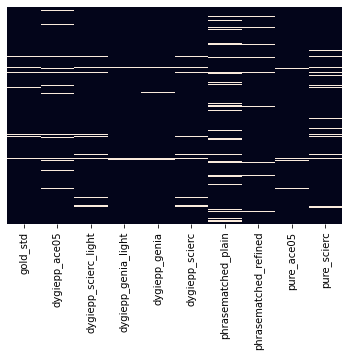

In [22]:
sns.heatmap(unigram_map, cbar=False, yticklabels=False)

<AxesSubplot:>

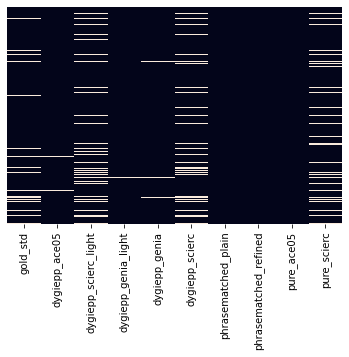

In [23]:
sns.heatmap(bigram_map, cbar=False, yticklabels=False)

<AxesSubplot:>

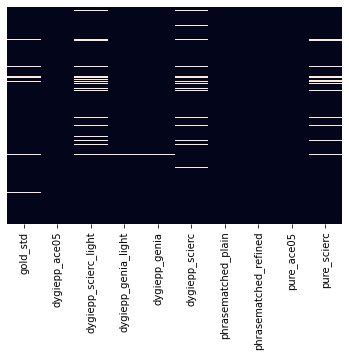

In [24]:
sns.heatmap(trigram_map, cbar=False, yticklabels=False)

Now, we want to drop all rows with 0's and organize the rows by sum.

In [33]:
# Drop 0 rows
unigram_map_s = unigram_map.loc[(unigram_map!=0).any(axis=1)].copy()
bigram_map_s = bigram_map.loc[(bigram_map!=0).any(axis=1)].copy()
trigram_map_s = trigram_map.loc[(trigram_map!=0).any(axis=1)].copy()

In [34]:
# Sort by sum
def sort_by_sum(df):
    """
    Sort a df in descending order by the sum along the rows.
    
    parameters:
        df, pandas df: df to sort
        
    returns:
        df, pandas df: sorted df
    """
    # Add a column with the row sums
    df["sum_column"] = df.sum(axis=1)

    # Sort by sum column
    df = df.sort_values("sum_column", ascending=False)

    # Drop sum column
    df = df.drop("sum_column", axis=1)
    
    return df

In [36]:
unigram_map_s = sort_by_sum(unigram_map_s)
bigram_map_s = sort_by_sum(bigram_map_s)
trigram_map_s = sort_by_sum(trigram_map_s)

<AxesSubplot:>

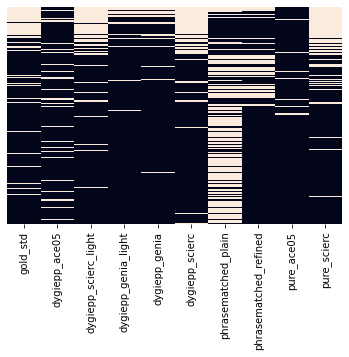

In [38]:
# Remake heatmaps
sns.heatmap(unigram_map_s, cbar=False, yticklabels=False)

<AxesSubplot:>

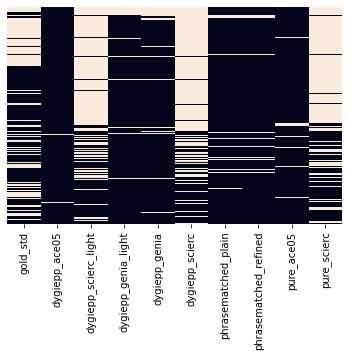

In [39]:
sns.heatmap(bigram_map_s, cbar=False, yticklabels=False)

<AxesSubplot:>

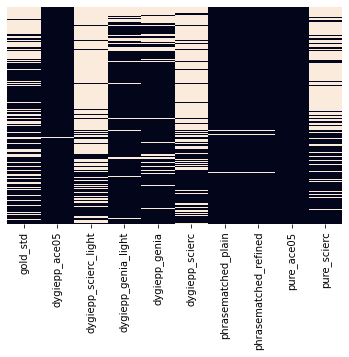

In [40]:
sns.heatmap(trigram_map_s, cbar=False, yticklabels=False)

## Prediction bar plots
Plotting the counts for how many models identified a given n-gram

In [53]:
# Groupby value to get counts
uni_counts = uni_sum.groupby(by=uni_sum).count()
bi_counts = bi_sum.groupby(by=bi_sum).count()
tri_counts = tri_sum.groupby(by=tri_sum).count()

In [61]:
# Define function to add value of bar above bar
# Code adapted from https://stackoverflow.com/a/42498711/13340814
def autolabel(rects, i):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axs[i].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

Text(0.9, 0.3, 'Number of component trigram tokens identified in at least one model: 1266')

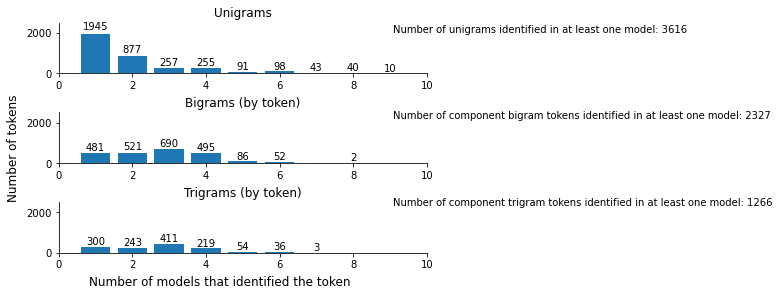

In [91]:
# Make barplot

# Make subplot axes
fig, axs = plt.subplots(3, constrained_layout=True)

# Enforce same x and y limit on all plots
plt.setp(axs, xlim=(0,10), ylim=(0,2500))

# Plot
uni_plot = axs[0].bar(uni_counts.index, uni_counts)
axs[0].set_title('Unigrams')
bi_plot  = axs[1].bar(bi_counts.index, bi_counts)
axs[1].set_title('Bigrams (by token)')
tri_plot = axs[2].bar(tri_counts.index, tri_counts)
axs[2].set_title('Trigrams (by token)')

# Label the bars
autolabel(uni_plot, 0)
autolabel(bi_plot, 1)
autolabel(tri_plot, 2)

# Make shared x and y labels
fig.supxlabel('Number of models that identified the token')
fig.supylabel('Number of tokens')

# Get rid of top and right lines on axes
for ax in axs:
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
# Add total number of grams in upper right corner
num_uni = uni_counts.sum()
fig.text(0.9, 0.9, f'Number of unigrams identified in at least one model: {num_uni}')
num_bi = bi_counts.sum()
fig.text(0.9, 0.6, f'Number of component bigram tokens identified in at least one model: {num_bi}')
num_tri = tri_counts.sum()
fig.text(0.9, 0.3, f'Number of component trigram tokens identified in at least one model: {num_tri}')